In [1]:
pip install pandas numpy matplotlib scikit-learn tensorflow


Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Loading AAPL historical dataset downloaded from Investing.com
filename = "AAPL.csv"  
raw = pd.read_csv(filename)


C:\Users\ACER\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [7]:
# Display the first few rows
raw.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,01/02/2026,271.01,272.26,277.84,269.00,37.84M,-0.31%
1,12/31/2025,271.86,273.06,273.68,271.75,27.29M,-0.45%
2,12/30/2025,273.08,272.81,274.08,272.28,22.14M,-0.25%
3,12/29/2025,273.76,272.69,274.36,272.35,23.72M,0.13%
4,12/26/2025,273.40,274.16,275.37,272.86,21.52M,-0.15%


In [8]:
#Display the last few row
raw.tail()

,Date,Price,Open,High,Low,Vol.,Change %
3516,01/09/2012,15.06,15.20,15.28,15.05,394.02M,-0.16%
3517,01/06/2012,15.09,14.99,15.10,14.97,318.39M,1.05%
3518,01/05/2012,14.93,14.82,14.95,14.74,271.27M,1.11%
3519,01/04/2012,14.77,14.64,14.81,14.62,260.24M,0.54%
3520,01/03/2012,14.69,14.62,14.73,14.61,302.26M,1.54%


In [9]:
#Shape of the dataset
raw.shape

(3521, 7)

In [10]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3521 entries, 0 to 3520
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      3521 non-null   object 
 1   Price     3521 non-null   float64
 2   Open      3521 non-null   float64
 3   High      3521 non-null   float64
 4   Low       3521 non-null   float64
 5   Vol.      3521 non-null   object 
 6   Change %  3521 non-null   object 
dtypes: float64(4), object(3)
memory usage: 192.7+ KB


In [11]:
df = raw.copy()
df.columns = [c.strip() for c in df.columns]

# Investing.com usually uses 'Price' for Close price
if "Price" in df.columns and "Close" not in df.columns:
    df.rename(columns={"Price": "Close"}, inplace=True)

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

df["Close"] = (
    df["Close"].astype(str)
    .str.replace(",", "", regex=False)
    .str.strip()
)
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")

df = df[["Date", "Close"]].dropna()
df = df.sort_values("Date").reset_index(drop=True)

print("Rows after cleaning:", len(df))
df.head()


Rows after cleaning: 3521


,Date,Close
0,2012-01-03,14.69
1,2012-01-04,14.77
2,2012-01-05,14.93
3,2012-01-06,15.09
4,2012-01-09,15.06


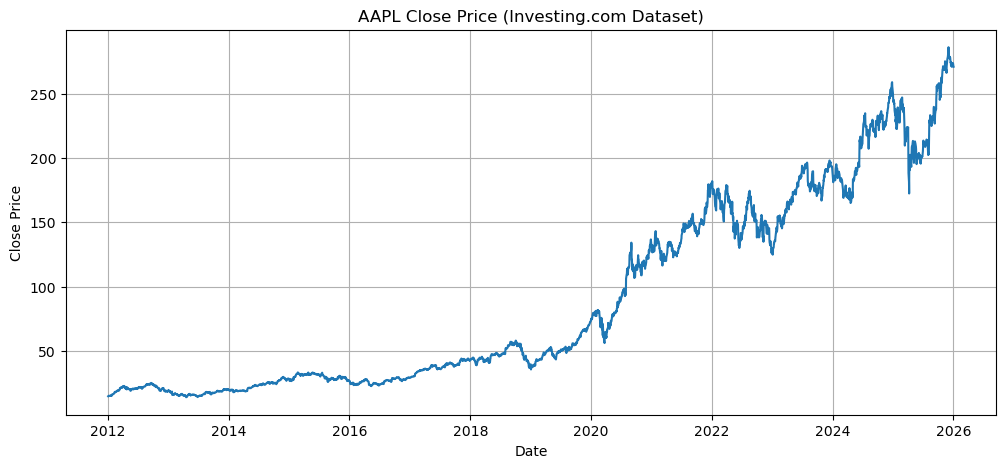

In [12]:
plt.figure(figsize=(12,5))
plt.plot(df["Date"], df["Close"])
plt.title("AAPL Close Price (Investing.com Dataset)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()


In [13]:
close_prices = df["Close"].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(close_prices)

SEQ_LEN = 60
if len(scaled) <= SEQ_LEN:
    SEQ_LEN = max(5, len(scaled)//3)
    print("Dataset small → SEQ_LEN changed to:", SEQ_LEN)

X, y = [], []
for i in range(SEQ_LEN, len(scaled)):
    X.append(scaled[i-SEQ_LEN:i, 0])
    y.append(scaled[i, 0])

X = np.array(X).reshape(-1, SEQ_LEN, 1)
y = np.array(y)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

test_dates = df["Date"].iloc[SEQ_LEN + split:].reset_index(drop=True)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (2768, 60, 1) Test: (693, 60, 1)


In [14]:
tf.random.set_seed(42)

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LEN, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer="adam", loss="mean_squared_error")

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=32,
    verbose=1
)


C:\Users\ACER\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0054 - val_loss: 0.0011
Epoch 2/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 6.9972e-04 - val_loss: 0.0015
Epoch 3/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 7.8972e-04 - val_loss: 0.0021
Epoch 4/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 5.5001e-04 - val_loss: 0.0019
Epoch 5/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 5.0913e-04 - val_loss: 9.4599e-04
Epoch 6/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 4.8216e-04 - val_loss: 0.0018
Epoch 7/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 4.0742e-04 - val_loss: 7.1793e-04
Epoch 8/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 4.5231e-04 - val_loss: 0.0010
Epoch 9/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 3.7918e-04 - val_loss: 0.0022
Epoch 10/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 3.8457e-04 - val_loss: 0.0012
Epoch 11/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 3.8903e-04 - val_loss: 6.6712e-04
Epoch 12/15

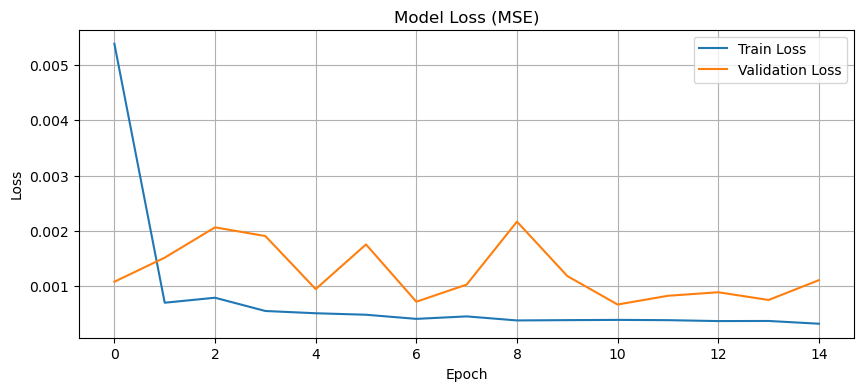

In [15]:
plt.figure(figsize=(10,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


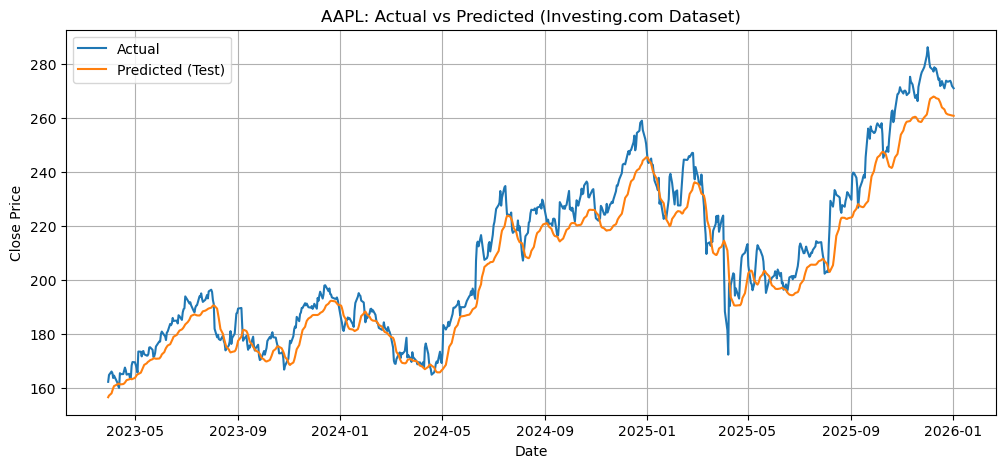

In [16]:
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1,1))

plt.figure(figsize=(12,5))
plt.plot(test_dates, actual, label="Actual")
plt.plot(test_dates, pred, label="Predicted (Test)")
plt.title("AAPL: Actual vs Predicted (Investing.com Dataset)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


C:\Users\ACER\AppData\Local\Temp\ipykernel_8112\252250287.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [float(pred[-1]), next_close],


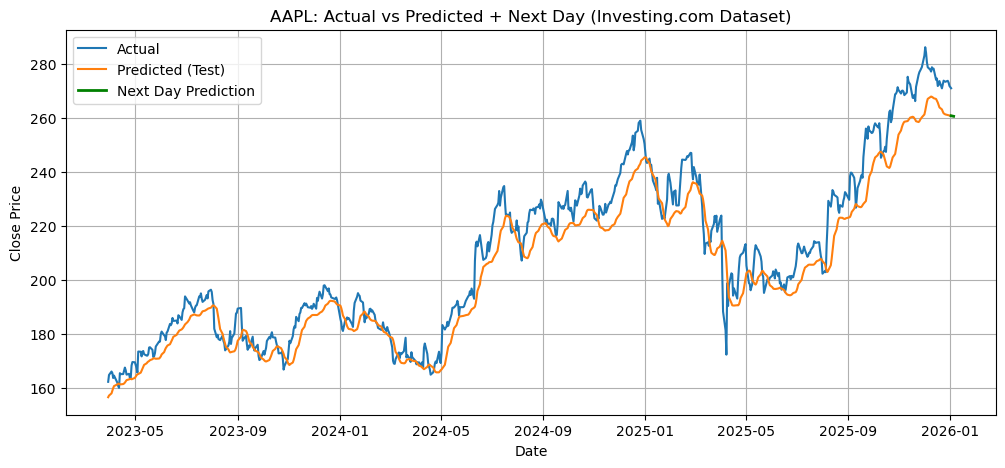

Next day predicted close: 260.6276550292969
Prediction date: 2026-01-05


In [17]:
last_seq = scaled[-SEQ_LEN:].reshape(1, SEQ_LEN, 1)
next_scaled = model.predict(last_seq)
next_close = float(scaler.inverse_transform(next_scaled)[0, 0])

last_date = pd.to_datetime(df["Date"].iloc[-1])
next_date = pd.bdate_range(last_date + pd.Timedelta(days=1), periods=1)[0]

plt.figure(figsize=(12,5))
plt.plot(test_dates, actual, label="Actual")
plt.plot(test_dates, pred, label="Predicted (Test)")

plt.plot(
    [pd.to_datetime(test_dates.iloc[-1]), next_date],
    [float(pred[-1]), next_close],
    linewidth=2,
    color="green",
    label="Next Day Prediction"
)

plt.title("AAPL: Actual vs Predicted + Next Day (Investing.com Dataset)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.legend()
plt.show()

print("Next day predicted close:", next_close)
print("Prediction date:", next_date.date())


In [52]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Convert LSTM 3D data to 2D for KNN and Random Forest
X_train_2d = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test_2d  = X_test.reshape(X_test.shape[0], X_test.shape[1])


In [54]:
# KNN Regressor
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_2d, y_train)

# Predict on test data
knn_pred_scaled = knn.predict(X_test_2d).reshape(-1, 1)
knn_pred = scaler.inverse_transform(knn_pred_scaled)

# Next-day prediction
last_seq_2d = scaled[-SEQ_LEN:].reshape(1, SEQ_LEN)
knn_next_scaled = knn.predict(last_seq_2d).reshape(-1, 1)
knn_next = float(scaler.inverse_transform(knn_next_scaled)[0, 0])


C:\Users\ACER\AppData\Local\Temp\ipykernel_8112\2667683303.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [float(knn_pred[-1]), knn_next],


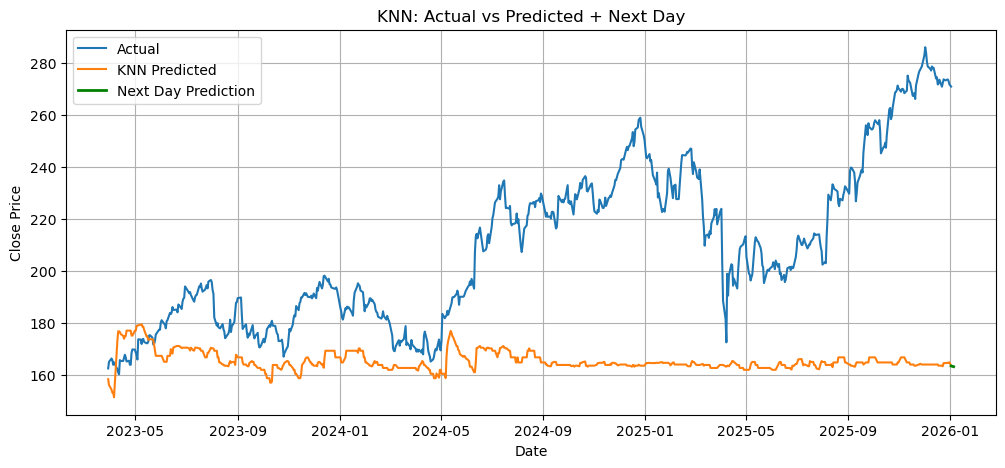

In [56]:
last_date = pd.to_datetime(df["Date"].iloc[-1])
next_date = pd.bdate_range(last_date + pd.Timedelta(days=1), periods=1)[0]

plt.figure(figsize=(12,5))
plt.plot(test_dates, actual, label="Actual")
plt.plot(test_dates, knn_pred, label="KNN Predicted")

plt.plot(
    [pd.to_datetime(test_dates.iloc[-1]), next_date],
    [float(knn_pred[-1]), knn_next],
    color="green",
    linewidth=2,
    label="Next Day Prediction"
)

plt.title("KNN: Actual vs Predicted + Next Day")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


In [58]:
# Random Forest Regressor
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_2d, y_train)

# Predict on test data
rf_pred_scaled = rf.predict(X_test_2d).reshape(-1, 1)
rf_pred = scaler.inverse_transform(rf_pred_scaled)

# Next-day prediction
rf_next_scaled = rf.predict(last_seq_2d).reshape(-1, 1)
rf_next = float(scaler.inverse_transform(rf_next_scaled)[0, 0])

C:\Users\ACER\AppData\Local\Temp\ipykernel_8112\3417982062.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [float(rf_pred[-1]), rf_next],


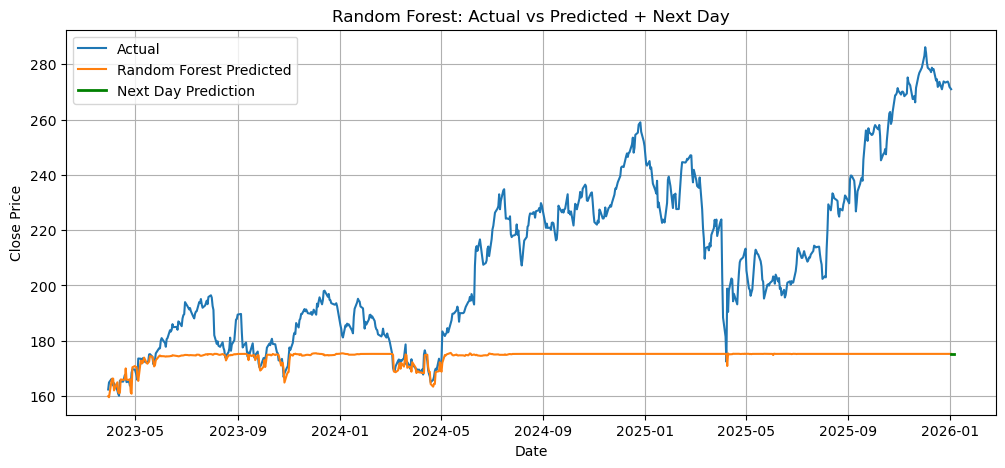

In [59]:
plt.figure(figsize=(12,5))
plt.plot(test_dates, actual, label="Actual")
plt.plot(test_dates, rf_pred, label="Random Forest Predicted")

plt.plot(
    [pd.to_datetime(test_dates.iloc[-1]), next_date],
    [float(rf_pred[-1]), rf_next],
    color="green",
    linewidth=2,
    label="Next Day Prediction"
)

plt.title("Random Forest: Actual vs Predicted + Next Day")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


In [60]:
lstm_rmse = np.sqrt(mean_squared_error(actual, pred))
knn_rmse  = np.sqrt(mean_squared_error(actual, knn_pred))
rf_rmse   = np.sqrt(mean_squared_error(actual, rf_pred))

print("RMSE Comparison (Lower is Better)")
print("LSTM :", lstm_rmse)
print("KNN  :", knn_rmse)
print("RF   :", rf_rmse)

print("\nNext-Day Predictions")
print("LSTM:", next_close)
print("KNN :", knn_next)
print("RF  :", rf_next)


RMSE Comparison (Lower is Better)
LSTM : 9.061205620872613
KNN  : 53.86872184605425
RF   : 45.56536200281786

Next-Day Predictions
LSTM: 260.6276550292969
KNN : 163.03000000000003
RF  : 175.24579999999986


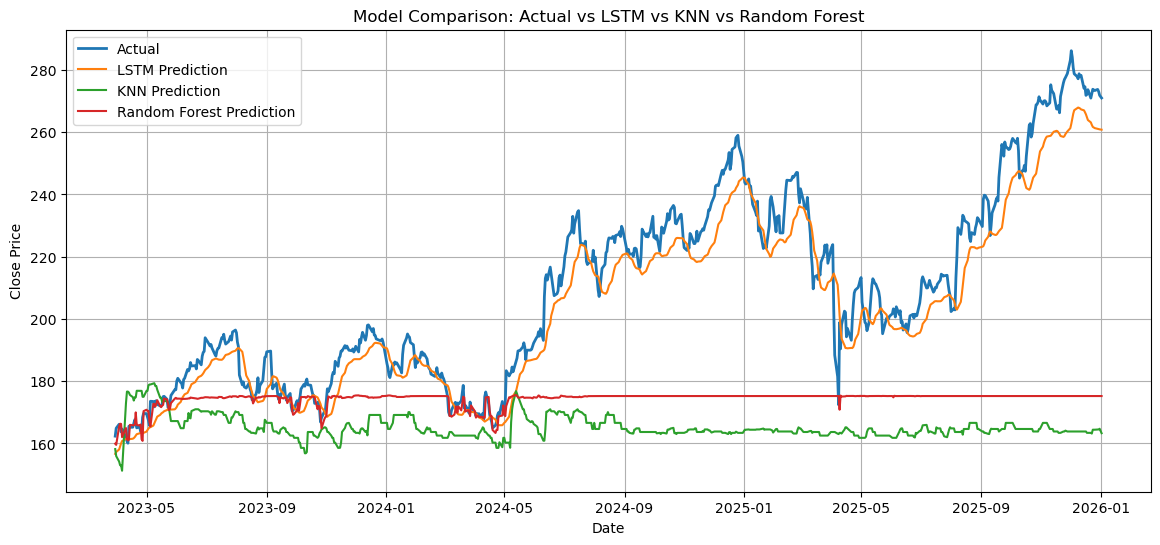

In [61]:
plt.figure(figsize=(14,6))

# Actual prices
plt.plot(test_dates, actual, label="Actual", linewidth=2)

# LSTM prediction
plt.plot(test_dates, pred, label="LSTM Prediction")

# KNN prediction
plt.plot(test_dates, knn_pred, label="KNN Prediction")

# Random Forest prediction
plt.plot(test_dates, rf_pred, label="Random Forest Prediction")

plt.title("Model Comparison: Actual vs LSTM vs KNN vs Random Forest")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()
